In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import pandas as pd

from datetime import datetime
import future
from memory_profiler import profile
import line_profiler
import gc

In [2]:
time_suffix = datetime.now().strftime("%y%m%d_%H%M%S")
time_suffix

'210504_201826'

In [3]:
from sklearn.metrics import mean_squared_error as MSE
from scipy import optimize as scop

In [4]:
from numba import njit
#@njit
@profile
def rush_larsen_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c[i-1])
 

In [5]:
if False:#True:
    t0 = np.arange(0,10,5e-6)
    tt = 10
    time = []
    for k in range(0, 78 * tt):
        time.append(t0[k])
    for k in range(0, 1000 * tt):
        time.append(t0[k])
    for k in range(0, 1000 * tt):
        time.append(t0[k])
    for k in range(0, 2000 * tt):
        time.append(t0[k])
    for k in range(0, 922 * tt):
        time.append(t0[k])
    np.save('time_5e-6', time)

t_step = np.load('time_1e-5.npy')
t_step[1]

1e-05

$$ \frac{\partial V_{p}}{\partial t} = \frac{V_{c} - V_{p}}{C_{p}*R_{p}} \\ $$
$$ \frac{\partial V_{m}}{\partial t} = \frac{V_{p} + V_{off} - V_{m}}{C_{m}*R_{s}} - \frac{I_{ion}+I_{leak}}{C_m} \\ $$
$$ \frac{\partial m}{\partial t} = \frac{m_{inf} - m}{\tau_{m}}  \\ $$
$$ \frac{\partial h}{\partial t} = \frac{h_{inf} - h}{\tau_{h}}  \\ $$
$$
I_{m} = C_{m} *\frac{\partial V_{m}}{\partial t} \\
I_{p} = C_{p} *\frac{\partial V_{p}}{\partial t} \\
I_{leak} = g_{leak} * V_{m}
$$

In [6]:
import ctypes 

# Загрузка библиотеки
test = ctypes.CDLL('./../data/functions/libtest.so')
test.calculate_circle.restype =  ctypes.c_void_p

test.calculate_circle.argtypes = [ctypes.c_int, ctypes.c_int,
                                 np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
                                 np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
                                 ctypes.c_double,
                                 np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
                                 np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
                                 np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
                                 np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
                                 np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
                                 np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
                                 np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
                                 np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
                                 np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
                                 np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')]

In [13]:
@njit
def rush_larsen_easy_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c)
        
#@njit
def euler_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = x[i-1] + (y[i-1] - x[i-1]) * c

#@profile
#@njit

#@profile
@njit
def calculate_circle(n, n_start, t, v_c, v_rev,v_cp,v_p,v_m,v_comp, m_inf,h_inf , m, h, j,I_leak, I_Na,args):
    
    c_p, c_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, a0_j, b0_j, delta_j, s_j,tau_j_const,\
    r_m, r_p, g_max, g_leak, v_half_m, v_half_h, k_m, k_h, x_c_comp, x_r_comp, alpha, v_off = args

    n_step = len(t)
    dt = t[1] - t[0]    
    time_ = len(t)
    
    I_leak[0] = g_leak * v_m[0]
    c_comp = x_c_comp*c_m
    r_comp = x_r_comp*r_m
    tau_srp = r_m * c_m * (1 - alpha)
    betta = 1/(1-alpha) - 1
   
    i=1
    circle = 0
    while i!= n_step:
        
        alpha_m  = a0_m * np.exp( v_m[i-1] / (s_m))
        beta_m = b0_m * np.exp( v_m[i-1] / (-delta_m))

        alpha_h  = a0_h * np.exp(v_m[i-1] / (-s_h))
        beta_h = b0_h * np.exp( v_m[i-1] / delta_h)

        #if False:
        #    alpha_m  = a0_m * np.exp( v_m / (s_m)) 
        #    beta_m = b0_m * np.exp( v_m / (-delta_m))

        #    alpha_h  = a0_h * np.exp(v_m / (s_h)) 
        #    beta_h = b0_h * np.exp( v_m/ (-delta_h))

        alpha_j  = a0_j * np.exp( v_m[i-1] / (s_j)) 
        beta_j = b0_j * np.exp( v_m[i-1] / (-delta_j))
        
        tau_m = 1 / (beta_m + alpha_m)#+0.000037
        tau_h = 1 / (beta_h + alpha_h)#+0.0002       
        tau_j = tau_j_const + 1 / (beta_j + alpha_j) 
              
        v_comp[i] = v_c[i-1] + (v_comp[i-1] - v_c[i-1]) * np.exp(-dt / tau_srp)
        v_cp[i] =  v_c[i-1] + (v_c[i-1] - v_comp[i-1])*betta 
        v_p[i] = v_cp[i-1] + (v_p[i-1] - v_cp[i-1]) * np.exp(-dt / (r_p * c_p))
        v_m[i] = v_m[i-1] + (v_p[i-1] + v_off - v_m[i-1] ) * (dt / (r_m * c_m)) - 1e-9 * (I_Na[i-1] + I_leak[i-1]) * dt / c_m 

        m[i] = m_inf + (m[i-1] - m_inf) * np.exp(-dt/tau_m)
        h[i] = h_inf + (h[i-1] - h_inf) * np.exp(-dt/tau_h)
        j[i] = h_inf + (j[i-1] - h_inf) * np.exp(-dt/tau_j)

        m_inf = 1 / (1 + np.exp((- v_half_m - v_m[i]) / k_m))
        h_inf = 1 / (1 + np.exp((v_half_h + v_m[i]) / k_h))

        I_leak[i] = g_leak * v_m[i]
        I_Na[i] = g_max * h[i] * (m[i]**3) * (v_m[i] - v_rev) * j[i] 
        if (i-1)/time_ == (i-1)//time_ and circle!=n_start :
            v_cp[i-1], v_p[i-1], v_m[i-1], v_comp[i-1], m_inf,\
            h_inf, m[i-1], h[i-1], j[i-1], I_leak[i-1], I_Na[i-1] = \
            v_cp[i], v_p[i], v_m[i], v_comp[i], m_inf, h_inf, m[i], h[i], j[i], I_leak[i], I_Na[i]
            circle += 1 
            #print(circle, i)
        else:
            circle = 0
            i+=1
    return  v_cp,  v_p, v_m, v_comp, I_leak, I_Na#tau_m[::n], tau_h[::n], tau_j[::n],


#@profile
def calculate_I_out(x, *args):#, s0, c, protocol, ...):
    #print(x)
    y = x.copy()
    kwargs = args[-1]
    
    t = kwargs['t']
    dt = t[1] - t[0]
    
    n = int(5e-5/dt)
    
    v_list = kwargs['v_list']
    k_list = kwargs['k_list'] * n
    
    if kwargs.get('log_scale', False):
        y[:-1] = np.exp(y[:-1])
        #y = np.exp(y)
        assert np.all(y[:-1] > 0) 
    #c_p, c_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, a0_j, b0_j, delta_j, s_j,tau_j_const,\
    #r_m, r_p, g_max, g_leak, v_half_m, v_half_h, k_m, k_h, x_c_comp, x_r_comp, alpha, v_off = y

    

    count = np.zeros_like(t)
    count[k_list] = 1
    count = np.cumsum(count) 
    
    
    v_c = np.zeros_like(t)
    v_c = v_list[count.astype(int)]

    v_rev = 18
   

    #
    v_cp = np.zeros_like(t)
    v_p = np.zeros_like(t)
    v_m = np.zeros_like(t)
    v_comp = np.zeros_like(t)
        
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    j = np.zeros_like(t)
    
    I_leak = np.zeros_like(t)
    I_Na = np.zeros_like(t)
    
    v_p[0] = -80.0
    v_m[0] = -80.0
    v_comp[0] =  - 80.0
    v_cp[0] =  - 80.0

    
    m[0] = 0.0
    h[0] = 1.0
    #n_step = len(t)
    
    #dt = t[1] - t[0]
    #time_ = 25000 
    #n_start = 15000
    n_start = 15000
    N = len(t)
    I_error = np.zeros(len(t)//n)
    try:
        #v_cp, v_p, v_m, v_comp, I_leak, I_Na = calculate_circle(n, n_start, t, v_c, v_rev,v_cp,v_p,v_m,v_comp, m_inf,h_inf ,m, h, j,I_leak, I_Na,y)
        test.calculate_circle(N, n_start, t, v_c, v_rev,v_cp,v_p,v_m,v_comp ,m, h, j,I_leak, I_Na,y)
    
    except ZeroDivisionError:
        I_error+=1e100
        return I_error
    
    c_p = y[0]
    c_m = y[1]
    x_c_comp = y[-4]

    I_c = 1e9 * c_m * (np.diff(v_m) / dt)[::n]
    I_p = 1e9 * c_p * (np.diff(v_p) / dt)[::n]
    I_comp=1e9 * x_c_comp* c_m * (np.diff(v_comp) / dt)[::n]
    
    if len(I_c) != len(I_Na[::n]):
        I_c = np.concatenate((I_c,I_c[-1:]))
        I_p = np.concatenate((I_p,I_p[-1:]))
        I_comp = np.concatenate((I_comp,I_comp[-1:]))
    
    tau_z = 5e-4 # 1e-12 * 5e8
    
    I_in = I_c  + I_leak[::n] + I_Na[::n] + I_p - I_comp
    del I_c, I_leak,I_Na,I_p,I_comp, v_cp, v_p, v_m, v_comp
    #gc.collect()
    I_out = np.zeros_like(I_in)

    I_out[0] = I_in[0]
    rush_larsen_easy_numba_helper(I_out, I_in, - dt * n / tau_z)
    #euler_numba_helper(I_out,I_in,(dt / tau_z))  
    del I_in
    if kwargs.get('graph', True):
        #plt.plot(V_m_list, label = 'command')
        plt.figure()
        
        plt.plot(v_c, label = 'command')
        #plt.plot(v_comp, label = 'compensated')
        plt.plot(v_cp, label = 'prediction')
        plt.plot(v_p, label = 'pipette', ls = '--')
        plt.plot(v_m, label = 'membrane',ls = '-.')
        plt.legend()
        v_graph = np.arange(-95,35)

        
        #plt.figure()
        #plt.plot( m_inf, label = 'm_inf')
        #plt.plot( h_inf, label = 'h_inf')
        #plt.legend()
        
        #plt.figure() 
        #tau_m_graph = 1 / (b0_m * np.exp((1-delta_m) * v_graph / (-s_m))
        #                  + a0_m * np.exp( v_m[i-1] / (s_m)) 
        #tau_h_graph = 1 / (b0_h * np.exp((1-delta_h) * v_graph / (-s_h))
        #                  + a0_h * np.exp(-delta_h * v_graph / (-s_h)))
        
        #tau_m_graph = 1 / (a0_m * np.exp( v_graph / (s_m))
         #                 +  b0_m * np.exp( v_graph / (-delta_m)))
        #tau_h_graph = 1 / (a0_h * np.exp(v_graph / (-s_h))
         #                 +  b0_h * np.exp( v_graph / (delta_h)))
        #tau_j_graph = tau_j_const + 1 / (a0_j * np.exp(v_graph / (s_j))
         #                 +  b0_j * np.exp( v_graph / (-delta_j)))
        #plt.plot(v_graph, tau_m_graph, label = 'tau_m')
        #plt.plot(v_graph, tau_h_graph, label = 'tau_h')
        #plt.plot(v_graph, tau_j_graph, label = 'tau_j')
        
        #plt.plot(tau_m, label = 'tau_m')
        #plt.plot(tau_h, label = 'tau_h')
        #plt.legend()

        plt.figure()
        plt.plot(I_c, label = 'I_c')
        plt.plot(I_p, label = 'I_p')
        plt.plot(I_leak, label = 'I_leak')
        plt.plot(I_Na, label = 'I_Na',ls = '-.')
        plt.legend()
        

        plt.figure()
        #plt.plot(I_in, label = 'I_in')
        plt.plot(I_out, label = 'I_out')
        plt.legend() 



    return I_out


In [14]:
k_list = np.array([77, 1077, 2077, 4077])
v_list = np.array([-80, -70, -80, -80])
k_all = k_list
v_all = v_list
for l in range(1,20):
    k_all = np.concatenate([k_all, k_list+5000*l])
    v_all = np.concatenate([v_all, v_list+[0,  0, 0, 5*l]])
v_all = np.concatenate([v_all,[-80]])
t = np.load('../data/time.npy')
t_all = np.concatenate([t for k in range(20)])


In [15]:
k_list_1 = np.array([77, 1077, 2077, 4077])
v_list_1 = np.array([-80.0,-70.0,-80.0, -10.0, -80.0])

In [16]:
def log_x(a):
    b = a.copy()
    b[2:10] = np.log(a[2:10])
    b[14:18] = np.log(a[14:18])
    return(b)


In [17]:
%matplotlib inline
#%matplotlib notebook
plt.style.use('../styles/general.mplstyle')

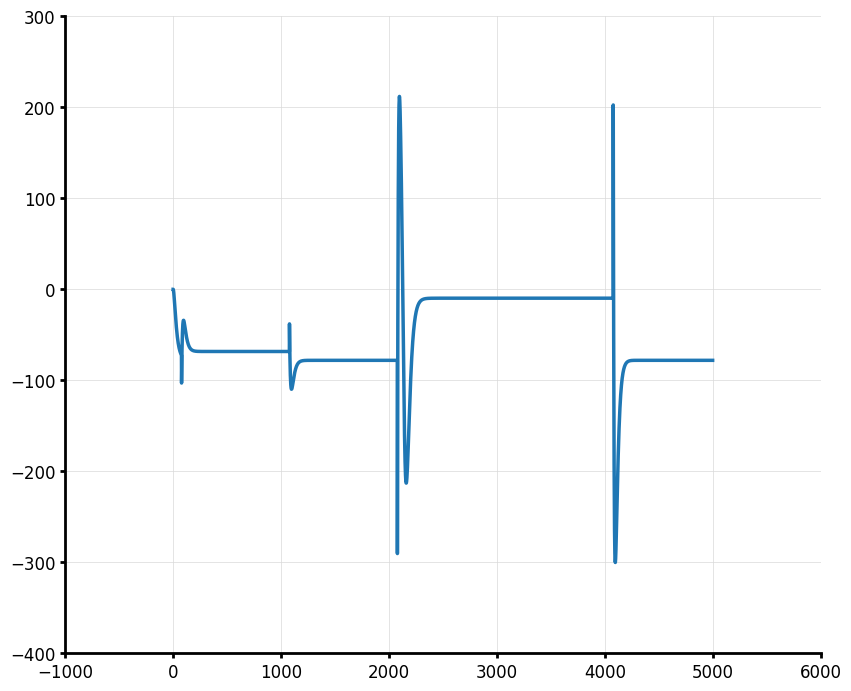

In [18]:
#p0 = np.array([6e-16, 6e-12, 2e3,  1.6e3,   0.9,   60,  1e-1,   4e2,    0.3,     3,    8e8,   5e3,  13,   2e-1, 11, 52,0.2,0.3,10])
#x_true = [6e-15, 12e-12, 5e4,  8e-2,   0.3,   60,  1e-3,   4e2,    0.08,     22,    5e8,   1e6,   5e1,   1e-1]
#p0 = np.array([6e-16, 5e-11, 90e+1,  3.9,8.21,   12.8,    6.3,   1.75e02,    6.72,  21.65,    5e6,   5e5,5e1,   5e-2,20,53,5,0.66, 5])
#             C_p     C     a0_m  b0_m  delta_m  s_m   a0_h  b0_h    delta_h      s_h      R    R_p   g_max  g_leak  "v_half_m", "v_half_h", "k_m", "k_h", "v_off"

#from Roman
#p0 = np.array([6e-16, 5e-11, 90e1,  3.9,   8.21,   12.8,    6.3,   1.75e02,    6.72,    21.65,   5e6,   5e4,  5e1,   5e-0,20,53,5,0.66, 0])
p0 = np.array([6.00e-13, 5.00e-11,#C_p , C
               2.40e+10, 6.90e+01, 1.2e-01, 2.86e+03,#a0_m , b0_m , delta_m , s_m 
               1.15e-01, 1.57e+03, 2.4e+01,  4.6e+01,#a0_h , b0_h , delta_h , s_h 
               3.13e+03, 1.13e-04, 8.28e+00, 3.84e+01, 2.00e-02,#a0_j , b0_j , delta_j , s_j , tau_j_const
               2.50e+07, 7.00e+04, 4.27e+02, 1.00e+0,#R , R_p , g_max , g_leak 
               1.04e+01, 4.64e+01, 1.30e+01, 2.80e-01,#v_half_m , v_half_h , k_m, k_h
               8.00e-01, 7.90e-01, 0.10e-03, 0.00e+00])# x_c_comp,x_r-Comp, alpha, v_off



if False:
    p0 = np.array([6.000e-16, 1.200e-11,#C_p , C
               9.454e+03, 1.931e-02, 5.955e+00, 3.477e+01,#a0_m , b0_m , delta_m , s_m 
               6.305e+03, 1.184e-02, 6.285e+00, 2.027e+01,#a0_h , b0_h , delta_h , s_h 
               3.132e+02, 1.132e-04, 8.281e+00, 3.845e+01, 2.038e-03,#a0_j , b0_j , delta_j , s_j , tau_j_const
               5.000e+07, 5.000e+05, 5.000e+02, 5.000e+4, #R , R_p , g_max , g_leak  
               2.000e+01, 5.300e+01, 5.000e+00, 6.600e-01,#v_half_m , v_half_h , k_m, k_h
               5.000e-01])#v_off


#x_true_log = np.log(p0)
x_true_log = np.concatenate((np.log(p0[:-1]),p0[-1:]))
#print(len(x_true_log))

#t = np.load('../data/time.npy')

v_list = v_all#np.array([-80, -80, -70, -80, -10, -80])
k_list = k_all#np.array([77, 1077, 2077, 4077]) 
dt = t[1] - t[0]

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t_step,
              log_scale = True,
              graph = False)#,
              #sample_weights = sample_weight)

data = calculate_I_out(x_true_log, kwargs)
#data1 = calculate_I_out_1(x_true_log, kwargs)


#print(p0)
#print(data)
plt.plot(data)
#np.save('data', data)
#plt.plot(np.load('data.npy'))
#plt.plot(data)
#plt.plot(data1)


In [19]:
print(len(t_step))

25000


In [13]:
#%matplotlib notebook
#plt.plot(v_c, label = 'command_prediction')
#plt.plot(v_p, label = 'pipette', ls = '--')
#plt.plot(v_m, label = 'membrane')
#plt.legend()
#v_graph = np.arange(-95,35)
#plt.show()

In [14]:
def loss(x, *args):
    kwargs = args[-1]
    data = args[0]
    sample_weight = kwargs.get('sample_weight', None)
    
    I_out = calculate_I_out(x, *args)
    
    if np.any(np.isnan(I_out)):
        return np.inf
    if np.any(np.isinf(I_out)):
        return np.inf
        
    return MSE(data, I_out, sample_weight=sample_weight)

In [15]:
%%timeit
#kwargs = dict(v_list = v_list_1,
#              k_list = k_list_1,
#              t = t,
#              log_scale = True,
#              graph = False)
loss(x_true_log, data, kwargs)

9.12 ms ± 423 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
names =  ["C_f","C",
          "a0_m","b0_m","delta_m","s_m",
          "a0_h","b0_h" ,"delta_h","s_h",
          "a0_j","b0_j" ,"delta_j","s_j","tau_j_const",
          "R"   , "R_f"  , "g_max"  ,"g_leak",
          "v_half_m", "v_half_h", "k_m", "k_h",
          "x_c_comp", "x_r_comp", "v_off" ]

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
x0 = x_true_log + 0.23
bounds = np.vstack([x_true_log  - 2, x_true_log + 2]).T#
#bounds = ([1e-18, 1e-13, 1e-10, 1e-10, -1e2,  1e-10, 1e-10, 1e-10, 1e-10,-1e3, 1e5,  1e3,  1e-5, 1e-5,  1e-4,     1e-4,   1e-4,1e-4,-50],
#          [1e-11,  1e-10, 1e8,   1e6,   1,      1e4,   1e8,   1e8,   1,     1e8,   1e15, 1e15, 1e5,  1e5,   100,      100,    1e2, 1e2,50])
log_bounds = np.vstack([np.concatenate((np.log(bounds[0][:-1]), bounds[0][-1:])),\
                        np.concatenate((np.log(bounds[1][:-1]), bounds[1][-1:]))]).T
#log_bounds = np.vstack([np.log(bounds[0]),np.log(bounds[1])]).T

loss(x0, data, kwargs)

In [22]:
%matplotlib inline
plt.style.use('../styles/general.mplstyle')

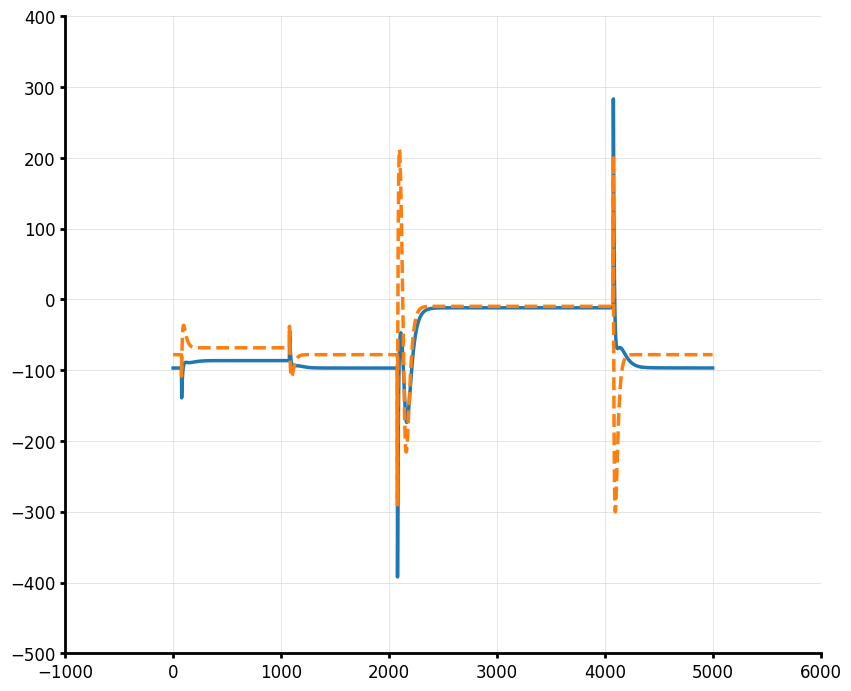

In [23]:
plt.plot(calculate_I_out(x0, kwargs))
plt.plot(data, '--')

### minimize

In [24]:
#%%time
#res = scop.minimize(loss, x0, bounds=bounds, args=(data, kwargs))
#C_p C a0_m b0_m  delta_m  s_m   a0_h  b0_h    delta_h      s_h      R    R_p   g_max  g_leak  "v_half_m", "v_half_h", "k_m", "k_h", "v_off"
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
res = scop.minimize(loss, x0, bounds = bounds, args=(data, kwargs),method = 'Nelder-Mead',
                    options={ 'adaptive':True, 'maxiter':10000})



/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


In [25]:
loss(res.x, data, kwargs)

0.2165917270601616

In [26]:
print('error in param = ' ,x_true_log - res.x)

error in param =  [-2.67336493e+00  6.28545446e-02 -1.76438145e+01 -3.41590689e+00
  2.60223153e-02 -7.49072318e+00 -1.99078575e+00 -8.43138987e-01
  1.14617250e+00 -4.91114689e+00  5.74219731e+00  7.94176118e+00
  1.78802472e+00  2.49300511e+00 -5.49998052e+00 -1.88271023e-01
 -5.76316432e+00  5.33334900e-01 -8.01586715e-03 -1.09926428e+00
 -4.87172317e-01 -2.55963575e-03  4.86992403e-01 -2.09058377e-01
 -2.23499323e-01  3.03661696e+00 -3.17243175e-01]


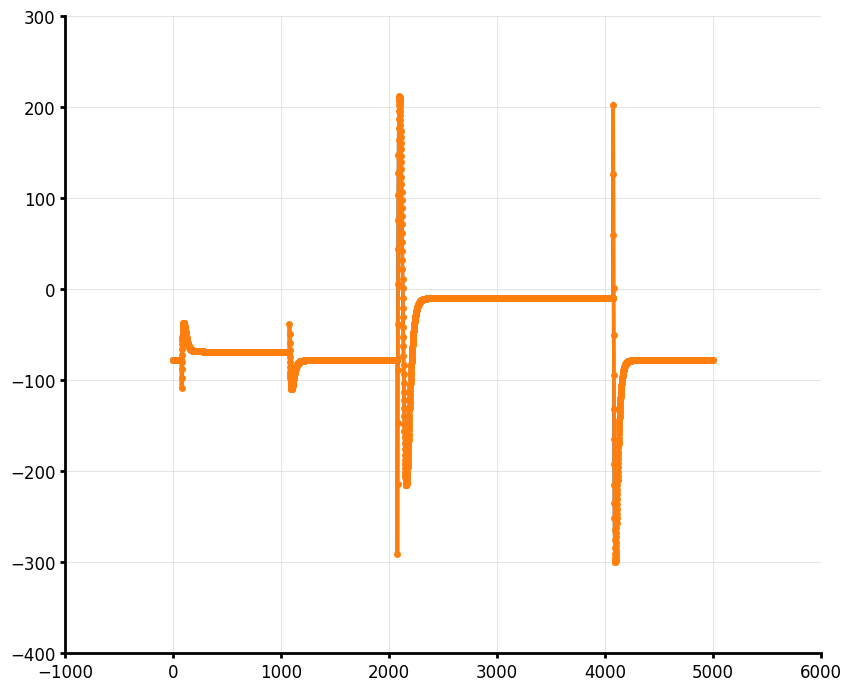

In [27]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '.-')

 ### real_data_minimize


In [28]:
import os
import pickle

In [29]:
def create_backup(*objects):

    folder_name = "../data/backups"
        
    time_suffix = datetime.now().strftime("%y%m%d_%H%M%S")
    
    folder_name = os.path.join(folder_name, time_suffix)
    os.makedirs(folder_name)
    
    backup_filename = os.path.join(folder_name, "backup.pickle")
    with open(backup_filename, 'wb') as f:
        pickle.dump(objects, f)
        
    return time_suffix
        

def recover_backup(time_suffix):
    
    folder_name = "../data/backups"

    folder_name = os.path.join(folder_name, time_suffix)
    
    backup_filename = os.path.join(folder_name, "backup.pickle")
    with open(backup_filename, 'rb') as f:
        objects = pickle.load(f)
        
    return objects

#ts = create_backup(res, calculate_I_out)
#ts

In [30]:
def get_full_trace(a):
    data = pd.read_csv( a ,delimiter= '\t', header=None, skiprows = 11)
    for k in range(1,21):
        print(np.mean(data[k][:77]),np.mean(data[k][4877:]))
#get_full_trace('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf')

In [31]:
def line(x,k,l):
    return k*x+l

In [32]:
def no_drift(data):
    v = 1
    final_data = np.zeros(len(data)*(len(data.columns)-1))
    list_drift = np.concatenate((np.arange(0,77),np.arange(1500,2077))) 
    dif=len(data[0])
    for k in range(1,len(data.columns)):
        x_0 = np.arange(dif)
        x = np.arange((k-1) * dif, k * dif)
        data_drift = data[k][list_drift]
        popt,pcov = scop.curve_fit(line, list_drift,data_drift)
        drift = line(x_0,*popt)[::v]
        final_data[(k-1) * dif : k * dif] = data[k] - drift
        #plt.plot(x[::v], data[k][::v])
        #plt.plot(x[::v], data[k][::v]-drift[::v])
        #plt.plot(x[::v], drift[::v])
    return final_data


In [33]:
def no_drift_single(data):
    v = 1
    final_data = np.zeros(len(data))#*(len(data.columns)-1))
    list_drift = np.concatenate((np.arange(0,77),np.arange(1500,2077))) 
    dif=len(data)
    x_0 = np.arange(dif)
    x = np.arange(0, dif)
    data_drift = data[list_drift]
    popt,pcov = scop.curve_fit(line, list_drift,data_drift)
    drift = line(x_0,*popt)[::v]
    final_data = data - drift
    #plt.plot(x[::v], data[k][::v])
    #plt.plot(x[::v], data[k][::v]-drift[::v])
    #plt.plot(x[::v], drift[::v])
    return final_data


In [34]:
#x_true_log = np.load('one_start_scop_minimize.npy')
sample_weight = np.zeros(5000)
w1 = 1
w2 = 5
w3 = 10
#sample_weight[:]+= 1
if True:
    sample_weight[:70] += w2
    sample_weight[90:500]+= w3
    sample_weight[500:1070] += w2
    sample_weight[1090:1500] += w3
    sample_weight[1500:2070] += w2
    sample_weight[2100:2400] += 30
    sample_weight[2400:4070] += w2
    sample_weight[4090:4500] += w3
    sample_weight[4500:] += w2
#sample_weight[k_list_1[2]+40:k_list_1[2]+900] += 1
#sample

In [35]:
%matplotlib inline
plt.style.use('../styles/general.mplstyle')

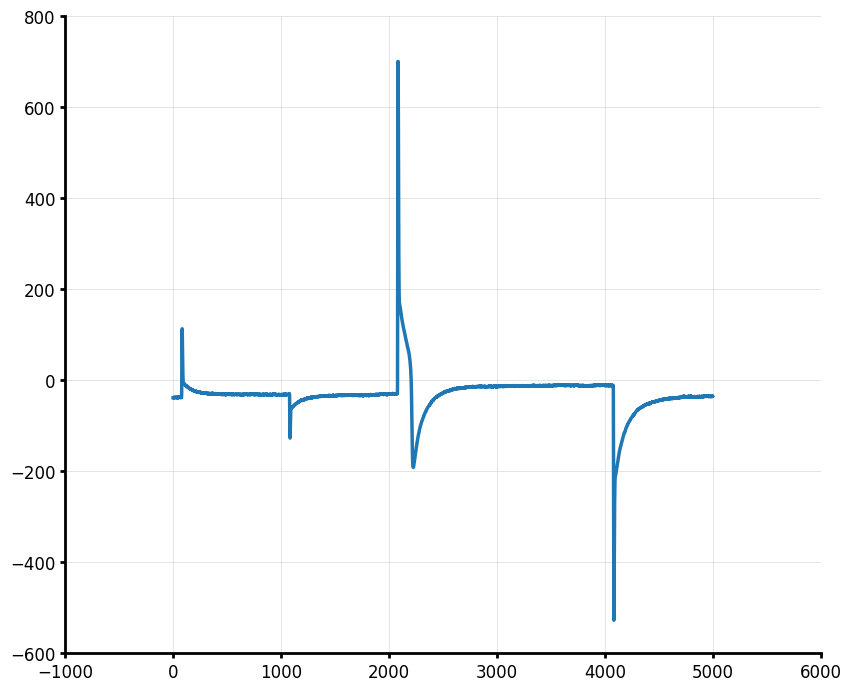

In [36]:
real_data = pd.read_csv('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_21_0007 I-V INa 15.80pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_22_0006 I-V INa 25.16pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_22_0032 I-V INa 21.05pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_23_0007 I-V INa E4031 33.16pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_26_0000 I-V INa 36.60pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_26_0014 I-V INa 15.78pF.atf' ,delimiter= '\t', header=None, skiprows = 11)

real_data_small = real_data[14]

#real_data_all = no_drift(real_data)#np.concatenate([real_data[k] for k in range(1,21)])

real_data_all = np.concatenate([real_data[k] for k in range(1,21)])
sample_weight_all = np.concatenate([sample_weight for k in range(1,21)])


#p0 = np.array([6e-16, 1.6e-10, 90e+1,  3.9,-8.21,   12.8,    6.3,   1.75e02,    6.72,  -21.65,    5e6,   5e5,5e1,   5e-2,20,53,5,0.66, 5])
                   
bounds = ([1e-18, 1e-13,#C_f , C 
           1e-06, 1e-06, 1e-03, 1e-03,# a0_m , b0_m , delta_m , s_m 
           1e-06, 1e-06, 1e-03, 1e-03,#a0_h , b0_h , delta_h , s_h
           1e-06, 1e-06, 1e-03, 1e-03, 1e-8,#a0_j , b0_j , delta_j , s_j, tau_j_const
           1e+05, 1e+03, 1e-05, 1e-05,#R , R_f , g_max , g_leak
           1e-04, 1e-04, 1e-04, 1e-04,#v_half_m , v_half_h , k_m , k_h
           1e-02, 1e-02, 1e-04, -5e+01],# x_c_comp,x_r-Comp alpha v_off
          
          
          [1e-10, 1e-10,#C_f , C 
           1e+06, 1e+06, 1e+03, 1e+03,# a0_m , b0_m , delta_m , s_m 
           1e+06, 1e+06, 1e+03, 1e+03,#a0_h , b0_h , delta_h , s_h
           1e+06, 1e+06, 1e+03, 1e+03, 1e+06,#a0_j , b0_j , delta_j , s_j, tau_j_const
           1e+10, 1e+12, 1e+05, 1e+05, #R , R_f , g_max , g_leak
           1e+02, 1e+02, 1e+02, 1e+02,#v_half_m , v_half_h , k_m , k_h
           1e+01, 1e+01, 1e+04, 5e+01])# x_c_comp,x_r-Comp alpha v_off
log_bounds = np.vstack([np.concatenate((np.log(bounds[0][:-1]), bounds[0][-1:]))
                        , np.concatenate((np.log(bounds[1][:-1]), bounds[1][-1:]))]).T
kwargs_for_count = dict(v_list = v_all,
              k_list = k_all,
              t = t_all,
              log_scale = True,
              graph = False,
              sample_weight = sample_weight_all)
plt.plot(real_data_small)

In [ ]:
#res = scop.minimize(loss, p0, bounds=log_bounds, args=(real_data_all, kwargs_for_count),method = 'Nelder-Mead',
#               options={ 'adaptive':True})

x = x_true_log

for k in range(5):
    res = scop.minimize(loss, x, bounds=log_bounds, args=(real_data_all, kwargs_for_count),method = 'Nelder-Mead',\
                    options={ 'adaptive':True, 'maxiter':1000})
    print('loop ',k ,': res.x = ', res.x,';\n          loss = ', loss(res.x, real_data_all, kwargs_for_count))
    x = res.x
#create_backup(res, calculate_I_out, kwargs, real_data_all, sample_weight_all)

In [ ]:
#np.save("res_maxiter_5000",res.x)
#np.save('maxiter_5000_best_fit',calculate_I_out(res.x, kwargs_for_count))
#create_backup(res, calculate_I_out, kwargs, real_data_all, sample_weight_all)

In [ ]:
%matplotlib notebook

In [ ]:
kwargs= dict(v_list = v_all,
              k_list = k_all,
              t = t_all,
              log_scale = True,
              graph = True,
              sample_weight = sample_weight_all)
plt.plot(calculate_I_out(res.x, kwargs_for_count), label = 'calculated')
plt.plot(real_data_all,'--', label = 'real_data')

plt.legend()


In [ ]:
x = calculate_I_out(res.x, kwargs_for_count) - real_data_all
x **= 2
x *= sample_weight_all
plt.plot(x, '.-', label = 'calculated')
#lt.xlim(2050,2200)

In [ ]:
np.sqrt(x[x <= 0.25e5].mean())

In [ ]:
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False,
              sample_weight = sample_weight)
plt.plot(real_data_small)
plt.plot(calculate_I_out(res.x, kwargs))

In [ ]:
%matplotlib inline

plt.style.use('../styles/general.mplstyle')

In [ ]:
real_data_small = np.concatenate([real_data[14] for k in range(4)])
t_2 = np.concatenate([t for k in range(4)])
#v_2 = np.concatenate([v_list_1 for k in range(4)])
v_2 = np.concatenate([np.array([-80,-70,-80, -10]) for k in range(4)])
k_2 = np.concatenate([k_list_1+5000*k for k in range(4)])
v_2 = np.concatenate([v_2,[-80]])
kwargs = dict(v_list = v_2,
              k_list = k_2,
              t = t_2,
              log_scale = True,
              graph = True)#,
              #sample_weight = sample_weight)
calculate_I_out(res.x, kwargs)
plt.plot(real_data_small, '--', label = 'real data')
plt.legend()

In [22]:
for k in range(len(res.x)):
    print(names[k], ' = ',np.exp(res.x)[k])

NameError: name 'res' is not defined

In [34]:
import tracemalloc
tracemalloc.start()

tb = tracemalloc.get_object_traceback(calculate_I_out)
import objgraph
objgraph.show_growth()

gc: collectable <traceback 0x7fb5a45df780>
gc: collectable <NameError 0x7fb5a459e9f0>
gc: collectable <traceback 0x7fb5a45d6b00>
gc: collectable <frame 0x2e7c270>
gc: collectable <frame 0x7fb5a45abe50>
gc: collectable <ExecutionResult 0x7fb5a456da00>
gc: collectable <dict 0x7fb5a4595380>
gc: collectable <ExecutionInfo 0x7fb5a456db20>
gc: collectable <type 0x4517d70>
gc: collectable <tuple 0x7fb55cd4cd80>
gc: collectable <dict 0x7fb5616d1200>
gc: collectable <tuple 0x7fb5a456d730>
gc: collectable <Module 0x7fb55c36b6d0>
gc: collectable <dict 0x7fb55c380880>
gc: collectable <NameScope 0x7fb55c36b700>
gc: collectable <dict 0x7fb55c410c40>
gc: collectable <collections.defaultdict 0x7fb55c36a0e0>
gc: collectable <collections.OrderedDict 0x7fb55c350240>
gc: collectable <list 0x7fb55c425740>
gc: collectable <GlobalVariable 0x7fb55c36b6a0>
gc: collectable <dict 0x7fb55c3eea40>
gc: collectable <Constant 0x7fb55c36b880>
gc: collectable <dict 0x7fb55c410440>
gc: collectable <Function 0x7fb55c36b8

gc: collectable <list 0x7fb55c2b15c0>
gc: collectable <PointerType 0x7fb55c2b5f40>
gc: collectable <VoidType 0x7fb55c23f040>
gc: collectable <list 0x7fb55c23c500>
gc: collectable <VoidType 0x7fb55c23f0a0>
gc: collectable <list 0x7fb55c2afdc0>
gc: collectable <VoidType 0x7fb55c23f130>
gc: collectable <list 0x7fb55c23c4c0>
gc: collectable <PointerType 0x7fb55c23f3a0>
gc: collectable <list 0x7fb55c240140>
gc: collectable <list 0x7fb55c239f00>
gc: collectable <list 0x7fb55c240100>
gc: collectable <PointerType 0x7fb55c23f760>
gc: collectable <VoidType 0x7fb55c23f820>
gc: collectable <list 0x7fb55c387b40>
gc: collectable <VoidType 0x7fb55c23f880>
gc: collectable <list 0x7fb55c240b80>
gc: collectable <VoidType 0x7fb55c23f910>
gc: collectable <list 0x7fb55c3841c0>
gc: collectable <PointerType 0x7fb55c23fa60>
gc: collectable <list 0x7fb55c240f00>
gc: collectable <list 0x7fb55c240cc0>
gc: collectable <PointerType 0x7fb55c23fbe0>
gc: collectable <list 0x7fb55c2431c0>
gc: collectable <list 0x7fb55

gc: collectable <Constant 0x7fb55c272e80>
gc: collectable <Constant 0x7fb55c272d60>
gc: collectable <dict 0x7fb55c276600>
gc: collectable <Constant 0x7fb55c1f80d0>
gc: collectable <Constant 0x7fb55c1f8070>
gc: collectable <dict 0x7fb55c276880>
gc: collectable <Constant 0x7fb55c1f8250>
gc: collectable <Constant 0x7fb55c1f81f0>
gc: collectable <dict 0x7fb55c276500>
gc: collectable <dict 0x7fb55c276840>
gc: collectable <dict 0x7fb55c276f40>
gc: collectable <Constant 0x7fb55c1f84c0>
gc: collectable <Constant 0x7fb55c1f8460>
gc: collectable <dict 0x7fb55c1fa5c0>
gc: collectable <Constant 0x7fb55c1f86a0>
gc: collectable <Constant 0x7fb55c1f8640>
gc: collectable <dict 0x7fb55c1fac00>
gc: collectable <Constant 0x7fb55c1f89d0>
gc: collectable <Constant 0x7fb55c1f8970>
gc: collectable <dict 0x7fb55c1fae80>
gc: collectable <Constant 0x7fb55c1f8b50>
gc: collectable <Constant 0x7fb55c1f8af0>
gc: collectable <dict 0x7fb55c1fab00>
gc: collectable <dict 0x7fb55c1fae40>
gc: collectable <dict 0x7fb55c1f

gc: collectable <dict 0x7fb55c1b79c0>
gc: collectable <list 0x7fb55c1b7a40>
gc: collectable <LoadInstr 0x7fb55c235e50>
gc: collectable <dict 0x7fb55c1b74c0>
gc: collectable <list 0x7fb55c1b7b00>
gc: collectable <ExtractValue 0x7fb55c1b9070>
gc: collectable <dict 0x7fb55c1b7880>
gc: collectable <list 0x7fb55c1b7c00>
gc: collectable <Instruction 0x7fb55c235f70>
gc: collectable <dict 0x7fb55c1b7780>
gc: collectable <list 0x7fb55c1b7d00>
gc: collectable <GEPInstr 0x7fb55c1b90a0>
gc: collectable <dict 0x7fb55c1b7fc0>
gc: collectable <list 0x7fb55c1bb080>
gc: collectable <LoadInstr 0x7fb55c1b9040>
gc: collectable <dict 0x7fb55c1b7700>
gc: collectable <list 0x7fb55c1bb140>
gc: collectable <CastInstr 0x7fb55c1b9190>
gc: collectable <dict 0x7fb55c1b7d80>
gc: collectable <list 0x7fb55c1bb1c0>
gc: collectable <Instruction 0x7fb55c1b9220>
gc: collectable <dict 0x7fb55c1bb240>
gc: collectable <list 0x7fb55c1bb2c0>
gc: collectable <CastInstr 0x7fb55c1b9250>
gc: collectable <dict 0x7fb55c1bb340>
gc: 

gc: collectable <Constant 0x7fb55c1f2490>
gc: collectable <dict 0x7fb55c1f3f00>
gc: collectable <Constant 0x7fb55c1f27c0>
gc: collectable <Constant 0x7fb55c1f2760>
gc: collectable <dict 0x7fb55c1f41c0>
gc: collectable <Constant 0x7fb55c1f2940>
gc: collectable <Constant 0x7fb55c1f28e0>
gc: collectable <dict 0x7fb55c1f3e00>
gc: collectable <dict 0x7fb55c1f4180>
gc: collectable <dict 0x7fb55c1f4880>
gc: collectable <Constant 0x7fb55c1f2bb0>
gc: collectable <Constant 0x7fb55c1f2b50>
gc: collectable <dict 0x7fb55c1f4ec0>
gc: collectable <Constant 0x7fb55c1f2d90>
gc: collectable <Constant 0x7fb55c1f2d30>
gc: collectable <dict 0x7fb55c1f6540>
gc: collectable <Constant 0x7fb55c177100>
gc: collectable <Constant 0x7fb55c1770a0>
gc: collectable <dict 0x7fb55c1f67c0>
gc: collectable <Constant 0x7fb55c177280>
gc: collectable <Constant 0x7fb55c177220>
gc: collectable <dict 0x7fb55c1f6440>
gc: collectable <dict 0x7fb55c1f6780>
gc: collectable <dict 0x7fb55c1f6f00>
gc: collectable <Constant 0x7fb55c17

gc: collectable <dict 0x7fb55c14a080>
gc: collectable <InsertValue 0x7fb55c149730>
gc: collectable <dict 0x7fb55c14a700>
gc: collectable <list 0x7fb55c14a800>
gc: collectable <ExtractValue 0x7fb55c1497c0>
gc: collectable <dict 0x7fb55c14a880>
gc: collectable <list 0x7fb55c14a940>
gc: collectable <GEPInstr 0x7fb55c149760>
gc: collectable <dict 0x7fb55c14ac00>
gc: collectable <list 0x7fb55c14ac80>
gc: collectable <LoadInstr 0x7fb55c149790>
gc: collectable <dict 0x7fb55c14a780>
gc: collectable <list 0x7fb55c14ad40>
gc: collectable <LoadInstr 0x7fb55c1498b0>
gc: collectable <dict 0x7fb55c14a9c0>
gc: collectable <list 0x7fb55c14adc0>
gc: collectable <ICMPInstr 0x7fb55c149940>
gc: collectable <dict 0x7fb55c14aec0>
gc: collectable <list 0x7fb55c14af40>
gc: collectable <GEPInstr 0x7fb55c1499a0>
gc: collectable <dict 0x7fb55c14c280>
gc: collectable <list 0x7fb55c14c300>
gc: collectable <StoreInstr 0x7fb55c149970>
gc: collectable <dict 0x7fb55c14ae40>
gc: collectable <list 0x7fb55c14c3c0>
gc: co

gc: collectable <dict 0x7fb55c0f8e40>
gc: collectable <dict 0x7fb55c0f8e00>
gc: collectable <dict 0x7fb55c0f94c0>
gc: collectable <dict 0x7fb55c0f9340>
gc: collectable <dict 0x7fb55c0f9980>
gc: collectable <dict 0x7fb55c0f9800>
gc: collectable <dict 0x7fb55c0f9e80>
gc: collectable <dict 0x7fb55c0f9e40>
gc: collectable <dict 0x7fb55c0fb440>
gc: collectable <dict 0x7fb55c0fb1c0>
gc: collectable <dict 0x7fb55c0fb7c0>
gc: collectable <dict 0x7fb55c0fb780>
gc: collectable <dict 0x7fb55c0fba40>
gc: collectable <dict 0x7fb55c0fb800>
gc: collectable <dict 0x7fb55c0fc140>
gc: collectable <dict 0x7fb55c0fc100>
gc: collectable <dict 0x7fb55c0fc780>
gc: collectable <dict 0x7fb55c0fc740>
gc: collectable <dict 0x7fb55c0fcdc0>
gc: collectable <dict 0x7fb55c0fcd80>
gc: collectable <dict 0x7fb55c0fe080>
gc: collectable <dict 0x7fb55c0fce00>
gc: collectable <dict 0x7fb55c0fe7c0>
gc: collectable <dict 0x7fb55c0fe780>
gc: collectable <dict 0x7fb55c0fedc0>
gc: collectable <dict 0x7fb55c0fed80>
gc: collecta

gc: collectable <list 0x7fb55c0d9a40>
gc: collectable <list 0x7fb55c0d97c0>
gc: collectable <Constant 0x7fb55c0c0d60>
gc: collectable <dict 0x7fb55c0c7240>
gc: collectable <Constant 0x7fb55c0c8760>
gc: collectable <Constant 0x7fb55c0c8850>
gc: collectable <dict 0x7fb55c0c9f40>
gc: collectable <Constant 0x7fb55c0c8ac0>
gc: collectable <Constant 0x7fb55c0c8c70>
gc: collectable <dict 0x7fb55c0cbac0>
gc: collectable <Constant 0x7fb55c0c8ee0>
gc: collectable <Constant 0x7fb55c0cc0d0>
gc: collectable <dict 0x7fb55c0cd640>
gc: collectable <Constant 0x7fb55c0cc340>
gc: collectable <Constant 0x7fb55c0cc4f0>
gc: collectable <dict 0x7fb55c0cf1c0>
gc: collectable <Constant 0x7fb55c0cc760>
gc: collectable <Constant 0x7fb55c0cc910>
gc: collectable <dict 0x7fb55c0cfd00>
gc: collectable <Constant 0x7fb55c0ccb80>
gc: collectable <Constant 0x7fb55c0ccd30>
gc: collectable <dict 0x7fb55c0d0880>
gc: collectable <Constant 0x7fb55c0ccfa0>
gc: collectable <Constant 0x7fb55c0d2190>
gc: collectable <dict 0x7fb5

gc: collectable <dict 0x7fb55c0a9180>
gc: collectable <list 0x7fb55c0a9a00>
gc: collectable <dict 0x7fb55c0a9a40>
gc: collectable <GlobalVariable 0x7fb55c0aa730>
gc: collectable <dict 0x7fb55c0a9f00>
gc: collectable <GlobalVariable 0x7fb55c0aa790>
gc: collectable <dict 0x7fb55c0a9f80>
gc: collectable <GlobalVariable 0x7fb55c0aaa30>
gc: collectable <dict 0x7fb55c0ab280>
gc: collectable <StoreInstr 0x7fb55c0aaa90>
gc: collectable <dict 0x7fb55c0ab240>
gc: collectable <list 0x7fb55c0ab1c0>
gc: collectable <LoadInstr 0x7fb55c0aa3a0>
gc: collectable <dict 0x7fb55c0a9a80>
gc: collectable <list 0x7fb55c0ab300>
gc: collectable <ICMPInstr 0x7fb55c0aa4f0>
gc: collectable <dict 0x7fb55c0ab380>
gc: collectable <list 0x7fb55c0ab400>
gc: collectable <LoadInstr 0x7fb55c0aa520>
gc: collectable <dict 0x7fb55c0a9b40>
gc: collectable <list 0x7fb55c0ab4c0>
gc: collectable <Ret 0x7fb55c0aa400>
gc: collectable <dict 0x7fb55c0ab540>
gc: collectable <list 0x7fb55c0ab600>
gc: collectable <dict 0x7fb55c0ab640>


gc: collectable <Constant 0x7fb55c05ec70>
gc: collectable <dict 0x7fb55c059140>
gc: collectable <Constant 0x7fb55c05a2b0>
gc: collectable <Constant 0x7fb55c05ed30>
gc: collectable <Constant 0x7fb55c0636d0>
gc: collectable <Constant 0x7fb55c063940>
gc: collectable <dict 0x7fb55c064840>
gc: collectable <Constant 0x7fb55c05eeb0>
gc: collectable <Constant 0x7fb55c063760>
gc: collectable <dict 0x7fb55c065d80>
gc: collectable <Constant 0x7fb55c063eb0>
gc: collectable <dict 0x7fb55c0661c0>
gc: collectable <Constant 0x7fb55c067100>
gc: collectable <Constant 0x7fb55c063f70>
gc: collectable <Constant 0x7fb55c067580>
gc: collectable <dict 0x7fb55c066240>
gc: collectable <dict 0x7fb55c065bc0>
gc: collectable <Constant 0x7fb55c063bb0>
gc: collectable <Constant 0x7fb55c063d90>
gc: collectable <Constant 0x7fb55c063dc0>
gc: collectable <dict 0x7fb55c06a840>
gc: collectable <Constant 0x7fb55c067490>
gc: collectable <Constant 0x7fb55c067f40>
gc: collectable <dict 0x7fb55c05b380>
gc: collectable <Constan

gc: collectable <Constant 0x7fb55bfb9490>
gc: collectable <Constant 0x7fb55bfb9370>
gc: collectable <dict 0x7fb55bfb8f80>
gc: collectable <Constant 0x7fb55bfb9730>
gc: collectable <Constant 0x7fb55bfb96d0>
gc: collectable <dict 0x7fb55bfbb1c0>
gc: collectable <Constant 0x7fb55bfb98b0>
gc: collectable <Constant 0x7fb55bfb9850>
gc: collectable <dict 0x7fb55bfb8e80>
gc: collectable <dict 0x7fb55bfbb180>
gc: collectable <dict 0x7fb55bfbb840>
gc: collectable <Constant 0x7fb55bfb9b20>
gc: collectable <Constant 0x7fb55bfb9ac0>
gc: collectable <Constant 0x7fb55bfb9c70>
gc: collectable <dict 0x7fb55bfbc280>
gc: collectable <Constant 0x7fb55bfb9dc0>
gc: collectable <Constant 0x7fb55bfb9d60>
gc: collectable <dict 0x7fb55bfbc500>
gc: collectable <Constant 0x7fb55bfb9f40>
gc: collectable <Constant 0x7fb55bfb9ee0>
gc: collectable <dict 0x7fb55bfbc180>
gc: collectable <dict 0x7fb55bfbc4c0>
gc: collectable <dict 0x7fb55bfbcc00>
gc: collectable <Constant 0x7fb55bfbd1f0>
gc: collectable <Constant 0x7fb5

gc: collectable <list 0x7fb55c2c8fc0>
gc: collectable <Constant 0x7fb55c040ee0>
gc: collectable <list 0x7fb55c2c8f00>
gc: collectable <list 0x7fb55c4761c0>
gc: collectable <list 0x7fb55c2c8700>
gc: collectable <PointerType 0x7fb55c04b9d0>
gc: collectable <list 0x7fb55c476ac0>
gc: collectable <list 0x7fb55c476c00>
gc: collectable <list 0x7fb55c4769c0>
gc: collectable <list 0x7fb55c476440>
gc: collectable <list 0x7fb55c4763c0>
gc: collectable <PointerType 0x7fb55c324ee0>
gc: collectable <list 0x7fb55c476c40>
gc: collectable <list 0x7fb55c476ec0>
gc: collectable <list 0x7fb55c476280>
gc: collectable <tuple 0x7fb55c2c2400>
gc: collectable <tuple 0x7fb55c334140>
gc: collectable <list 0x7fb55c476300>
gc: collectable <list 0x7fb55c476900>
gc: collectable <list 0x7fb55c2c1d00>
gc: collectable <PointerType 0x7fb55bfd8f70>
gc: collectable <VoidType 0x7fb55bfda2b0>
gc: collectable <list 0x7fb55c3348c0>
gc: collectable <list 0x7fb55c2c1540>
gc: collectable <VoidType 0x7fb55bfda5b0>
gc: collectable

gc: collectable <PointerType 0x7fb55bf981f0>
gc: collectable <list 0x7fb55bf9a540>
gc: collectable <list 0x7fb55bf9a240>
gc: collectable <list 0x7fb55bf9a500>
gc: collectable <ArrayType 0x7fb55bf98490>
gc: collectable <list 0x7fb55bf9a700>
gc: collectable <Constant 0x7fb55bf98160>
gc: collectable <list 0x7fb55bf9a4c0>
gc: collectable <list 0x7fb55bf9a900>
gc: collectable <list 0x7fb55bf9a780>
gc: collectable <PointerType 0x7fb55bf985e0>
gc: collectable <list 0x7fb55bf9ac40>
gc: collectable <list 0x7fb55bf9aa00>
gc: collectable <list 0x7fb55bf9ac00>
gc: collectable <list 0x7fb55bf9ae40>
gc: collectable <list 0x7fb55bf9ae00>
gc: collectable <PointerType 0x7fb55bf98790>
gc: collectable <list 0x7fb55bf9b1c0>
gc: collectable <list 0x7fb55bf9af40>
gc: collectable <list 0x7fb55bf9b180>
gc: collectable <tuple 0x7fb55bf80d80>
gc: collectable <tuple 0x7fb55bf99500>
gc: collectable <list 0x7fb55bf9b680>
gc: collectable <list 0x7fb55bf9b380>
gc: collectable <list 0x7fb55bf99e00>
gc: collectable <P

gc: collectable <list 0x7fb55bf61400>
gc: collectable <list 0x7fb55bf60d00>
gc: collectable <VoidType 0x7fb55bf63040>
gc: collectable <list 0x7fb55bf60cc0>
gc: collectable <list 0x7fb55bf60dc0>
gc: collectable <VoidType 0x7fb55bf63130>
gc: collectable <list 0x7fb55bf61440>
gc: collectable <list 0x7fb55bf60d80>
gc: collectable <tuple 0x7fb55bf9e0c0>
gc: collectable <PointerType 0x7fb55bf633a0>
gc: collectable <VoidType 0x7fb55bf634c0>
gc: collectable <list 0x7fb55bf62980>
gc: collectable <list 0x7fb55bf62d40>
gc: collectable <VoidType 0x7fb55bf634f0>
gc: collectable <list 0x7fb55bf62e40>
gc: collectable <list 0x7fb55bf62e00>
gc: collectable <list 0x7fb55bf651c0>
gc: collectable <AnsiToWin32 0x7fb55bf63b50>
gc: collectable <AnsiToWin32 0x7fb55bf63be0>
gc: collectable <list 0x7fb55bf65b00>
gc: collectable <LabelType 0x7fb55bf63e50>
gc: collectable <LabelType 0x7fb55bf63eb0>
gc: collectable <VoidType 0x7fb55bf63f10>
gc: collectable <list 0x7fb55bf65fc0>
gc: collectable <VoidType 0x7fb55bf6

gc: collectable <list 0x7fb55bf23200>
gc: collectable <list 0x7fb55bf22b80>
gc: collectable <PointerType 0x7fb55bf250d0>
gc: collectable <list 0x7fb55bf23480>
gc: collectable <list 0x7fb55bf23180>
gc: collectable <list 0x7fb55bf23440>
gc: collectable <ArrayType 0x7fb55bf1dee0>
gc: collectable <list 0x7fb55bf23640>
gc: collectable <Constant 0x7fb55bf250a0>
gc: collectable <list 0x7fb55bf23400>
gc: collectable <list 0x7fb55bf23840>
gc: collectable <list 0x7fb55bf236c0>
gc: collectable <PointerType 0x7fb55bf25340>
gc: collectable <list 0x7fb55bf23b80>
gc: collectable <list 0x7fb55bf23940>
gc: collectable <list 0x7fb55bf23b40>
gc: collectable <list 0x7fb55bf23d80>
gc: collectable <list 0x7fb55bf23d40>
gc: collectable <PointerType 0x7fb55bf254f0>
gc: collectable <list 0x7fb55bf26100>
gc: collectable <list 0x7fb55bf23e80>
gc: collectable <list 0x7fb55bf260c0>
gc: collectable <tuple 0x7fb55bf17900>
gc: collectable <tuple 0x7fb55bf0e200>
gc: collectable <list 0x7fb55bf265c0>
gc: collectable <l

gc: collectable <dict 0x7fb55bf12680>
gc: collectable <Function 0x7fb55be4a520>
gc: collectable <dict 0x7fb55be8f280>
gc: collectable <NameScope 0x7fb55be4a100>
gc: collectable <dict 0x7fb55be8fc40>
gc: collectable <collections.defaultdict 0x7fb55be7c2c0>
gc: collectable <list 0x7fb55be80cc0>
gc: collectable <FunctionAttributes 0x7fb55be402e0>
gc: collectable <tuple 0x7fb55bef17c0>
gc: collectable <ReturnValue 0x7fb55be4a490>
gc: collectable <dict 0x7fb55be8c480>
gc: collectable <ArgumentAttributes 0x7fb55be40ac0>
gc: collectable <AllocaInstr 0x7fb55be4a070>
gc: collectable <dict 0x7fb55bf04040>
gc: collectable <list 0x7fb55bf0ecc0>
gc: collectable <StoreInstr 0x7fb55be47250>
gc: collectable <dict 0x7fb55be8cb40>
gc: collectable <list 0x7fb55be4ccc0>
gc: collectable <StoreInstr 0x7fb55be47dc0>
gc: collectable <dict 0x7fb55be8f480>
gc: collectable <list 0x7fb55be4cdc0>
gc: collectable <AllocaInstr 0x7fb55be470a0>
gc: collectable <dict 0x7fb55be8f040>
gc: collectable <list 0x7fb55be4ce40

gc: collectable <dict 0x7fb55be67bc0>
gc: collectable <dict 0x7fb55be67d80>
gc: collectable <dict 0x7fb55be67a40>
gc: collectable <dict 0x7fb55be4d9c0>
gc: collectable <dict 0x7fb55be4df00>
gc: collectable <dict 0x7fb55be4da80>
gc: collectable <dict 0x7fb55be4dec0>
gc: collectable <dict 0x7fb55bdfb0c0>
gc: collectable <dict 0x7fb55bdfbf40>
gc: collectable <dict 0x7fb55bdfba80>
gc: collectable <dict 0x7fb55be69b40>
gc: collectable <dict 0x7fb55be69a00>
gc: collectable <dict 0x7fb55be69e40>
gc: collectable <dict 0x7fb55be69b00>
gc: collectable <dict 0x7fb55be69300>
gc: collectable <dict 0x7fb55be69240>
gc: collectable <dict 0x7fb55be69780>
gc: collectable <dict 0x7fb55be00880>
gc: collectable <dict 0x7fb55be00dc0>
gc: collectable <dict 0x7fb55be00e80>
gc: collectable <dict 0x7fb55be007c0>
gc: collectable <dict 0x7fb55be00940>
gc: collectable <dict 0x7fb55be006c0>
gc: collectable <dict 0x7fb55be07040>
gc: collectable <dict 0x7fb55be07140>
gc: collectable <Instruction 0x7fb55be08b50>
gc: c

gc: collectable <GEPInstr 0x7fb55bdb8760>
gc: collectable <dict 0x7fb55bdc0ec0>
gc: collectable <list 0x7fb55bdc0f40>
gc: collectable <LoadInstr 0x7fb55bdb84c0>
gc: collectable <dict 0x7fb55bdc07c0>
gc: collectable <list 0x7fb55bdbf040>
gc: collectable <dict 0x7fb55bdc0a00>
gc: collectable <InsertValue 0x7fb55bdb8940>
gc: collectable <dict 0x7fb55bdbf0c0>
gc: collectable <list 0x7fb55bdbf1c0>
gc: collectable <ExtractValue 0x7fb55bdb89d0>
gc: collectable <dict 0x7fb55bdbf240>
gc: collectable <list 0x7fb55bdbf300>
gc: collectable <GEPInstr 0x7fb55bdb8970>
gc: collectable <dict 0x7fb55bdbf600>
gc: collectable <list 0x7fb55bdbf680>
gc: collectable <LoadInstr 0x7fb55bdb89a0>
gc: collectable <dict 0x7fb55bdbf140>
gc: collectable <list 0x7fb55bdbf740>
gc: collectable <ExtractValue 0x7fb55bdb8b80>
gc: collectable <dict 0x7fb55bdbf4c0>
gc: collectable <list 0x7fb55bdbf840>
gc: collectable <GEPInstr 0x7fb55bdb8ac0>
gc: collectable <dict 0x7fb55bdbfb40>
gc: collectable <list 0x7fb55bdbfbc0>
gc: c

gc: collectable <list 0x7fb55bd9e3c0>
gc: collectable <list 0x7fb55bd9c080>
gc: collectable <VoidType 0x7fb55bda0100>
gc: collectable <list 0x7fb55bd9f780>
gc: collectable <dict 0x7fb55bd90e80>
gc: collectable <Constant 0x7fb55bd8d8e0>
gc: collectable <Constant 0x7fb55bd8dbb0>
gc: collectable <dict 0x7fb55bd89c80>
gc: collectable <Constant 0x7fb55bd8a0a0>
gc: collectable <Constant 0x7fb55bd8a1f0>
gc: collectable <dict 0x7fb55bd88940>
gc: collectable <Constant 0x7fb55bd87c40>
gc: collectable <Constant 0x7fb55bd87a30>
gc: collectable <dict 0x7fb55bd88840>
gc: collectable <Constant 0x7fb55bd87a60>
gc: collectable <Constant 0x7fb55bd87b80>
gc: collectable <dict 0x7fb55bd88780>
gc: collectable <dict 0x7fb55bd88980>
gc: collectable <dict 0x7fb55bd941c0>
gc: collectable <Constant 0x7fb55bd81f10>
gc: collectable <Constant 0x7fb55bd81f70>
gc: collectable <Constant 0x7fb55bd93190>
gc: collectable <dict 0x7fb55bd94bc0>
gc: collectable <Constant 0x7fb55bd932b0>
gc: collectable <Constant 0x7fb55bd9

gc: collectable <dict 0x7fb55bd6e700>
gc: collectable <list 0x7fb55bd6e780>
gc: collectable <LoadInstr 0x7fb55bd5e640>
gc: collectable <dict 0x7fb55bd6c3c0>
gc: collectable <list 0x7fb55bd6e840>
gc: collectable <ExtractValue 0x7fb55bd6a4c0>
gc: collectable <dict 0x7fb55bd6ea80>
gc: collectable <list 0x7fb55bd6eb00>
gc: collectable <ExtractValue 0x7fb55bd6a5b0>
gc: collectable <dict 0x7fb55bd6ed80>
gc: collectable <list 0x7fb55bd6edc0>
gc: collectable <ExtractValue 0x7fb55bd6a5e0>
gc: collectable <dict 0x7fb55bd6ee40>
gc: collectable <list 0x7fb55bd6ee80>
gc: collectable <ExtractValue 0x7fb55bd6a610>
gc: collectable <dict 0x7fb55bd6ef00>
gc: collectable <list 0x7fb55bd6ef40>
gc: collectable <ExtractValue 0x7fb55bd6a640>
gc: collectable <dict 0x7fb55bd6f040>
gc: collectable <list 0x7fb55bd6f080>
gc: collectable <ExtractValue 0x7fb55bd6a670>
gc: collectable <dict 0x7fb55bd6f1c0>
gc: collectable <list 0x7fb55bd6f200>
gc: collectable <ExtractValue 0x7fb55bd6a6a0>
gc: collectable <dict 0x7fb

gc: collectable <dict 0x7fb55bbdc100>
gc: collectable <list 0x7fb55bbf4040>
gc: collectable <LoadInstr 0x7fb55bbc4e50>
gc: collectable <dict 0x7fb55bbd3f40>
gc: collectable <list 0x7fb55bbf40c0>
gc: collectable <AllocaInstr 0x7fb55bbe53d0>
gc: collectable <dict 0x7fb55bbf4240>
gc: collectable <list 0x7fb55bbf42c0>
gc: collectable <StoreInstr 0x7fb55bbe54f0>
gc: collectable <dict 0x7fb55bbf4380>
gc: collectable <list 0x7fb55bbf4400>
gc: collectable <StoreInstr 0x7fb55bbe5550>
gc: collectable <dict 0x7fb55bbf4200>
gc: collectable <list 0x7fb55bbf44c0>
gc: collectable <CastInstr 0x7fb55bbe5580>
gc: collectable <dict 0x7fb55bbf4100>
gc: collectable <list 0x7fb55bbf4180>
gc: collectable <CallInstr 0x7fb55bbe55e0>
gc: collectable <dict 0x7fb55bbf45c0>
gc: collectable <CallInstrAttributes 0x7fb55bbe0900>
gc: collectable <list 0x7fb55bbdc900>
gc: collectable <list 0x7fb55bbf46c0>
gc: collectable <GEPInstr 0x7fb55bbe55b0>
gc: collectable <dict 0x7fb55bbf48c0>
gc: collectable <list 0x7fb55bbf494

gc: collectable <list 0x7fb55baa6580>
gc: collectable <list 0x7fb55baa6b40>
gc: collectable <ExtractValue 0x7fb55baa4220>
gc: collectable <dict 0x7fb55baa6c00>
gc: collectable <list 0x7fb55baa6c40>
gc: collectable <ExtractValue 0x7fb55baa42b0>
gc: collectable <dict 0x7fb55baa6cc0>
gc: collectable <list 0x7fb55baa6d00>
gc: collectable <ExtractValue 0x7fb55baa4280>
gc: collectable <dict 0x7fb55baa6dc0>
gc: collectable <list 0x7fb55baa6e00>
gc: collectable <ExtractValue 0x7fb55baa42e0>
gc: collectable <dict 0x7fb55baa6f00>
gc: collectable <list 0x7fb55baa6f40>
gc: collectable <ExtractValue 0x7fb55baa4310>
gc: collectable <dict 0x7fb55baa80c0>
gc: collectable <list 0x7fb55baa8100>
gc: collectable <ExtractValue 0x7fb55baa4340>
gc: collectable <dict 0x7fb55baa8200>
gc: collectable <list 0x7fb55baa8240>
gc: collectable <ExtractValue 0x7fb55baa43a0>
gc: collectable <dict 0x7fb55baa8380>
gc: collectable <list 0x7fb55baa8440>
gc: collectable <ExtractValue 0x7fb55baa4370>
gc: collectable <dict 0x

gc: collectable <PointerType 0x7fb55ba2a970>
gc: collectable <VoidType 0x7fb55ba2aa60>
gc: collectable <list 0x7fb55ba2bbc0>
gc: collectable <PointerType 0x7fb55ba2ab80>
gc: collectable <list 0x7fb55ba2bf00>
gc: collectable <list 0x7fb55ba2bd00>
gc: collectable <VoidType 0x7fb55ba2ab50>
gc: collectable <list 0x7fb55ba2bec0>
gc: collectable <PointerType 0x7fb55ba2ad30>
gc: collectable <list 0x7fb55ba2c2c0>
gc: collectable <list 0x7fb55ba2be80>
gc: collectable <VoidType 0x7fb55ba2ad00>
gc: collectable <list 0x7fb55ba2c280>
gc: collectable <PointerType 0x7fb55ba2aee0>
gc: collectable <list 0x7fb55ba2c640>
gc: collectable <list 0x7fb55ba2c240>
gc: collectable <VoidType 0x7fb55ba2aeb0>
gc: collectable <list 0x7fb55ba2c600>
gc: collectable <dict 0x7fb55ba57b40>
gc: collectable <dict 0x7fb55c335d00>
gc: collectable <dict 0x7fb55c36ff80>
gc: collectable <dict 0x7fb55c3b9d80>
gc: collectable <dict 0x7fb55c335f00>
gc: collectable <dict 0x7fb55c335880>
gc: collectable <dict 0x7fb55c36f2c0>
gc: co

gc: collectable <dict 0x7fb55b9c3040>
gc: collectable <list 0x7fb55b9c3980>
gc: collectable <StoreInstr 0x7fb55b9bcbe0>
gc: collectable <dict 0x7fb55b9c3a40>
gc: collectable <list 0x7fb55b9c3ac0>
gc: collectable <Ret 0x7fb55b9bcc40>
gc: collectable <dict 0x7fb55b9c3b80>
gc: collectable <list 0x7fb55b9c3c00>
gc: collectable <Branch 0x7fb55c368bb0>
gc: collectable <dict 0x7fb55b9c3640>
gc: collectable <list 0x7fb55c3e0680>
gc: collectable <PointerType 0x7fb55b9b92e0>
gc: collectable <list 0x7fb55b9b8940>
gc: collectable <list 0x7fb55b9b8bc0>
gc: collectable <list 0x7fb55b9b88c0>
gc: collectable <list 0x7fb55b9b8a40>
gc: collectable <list 0x7fb55b9b8840>
gc: collectable <tuple 0x7fb55c42bfc0>
gc: collectable <list 0x7fb55b9b8740>
gc: collectable <PointerType 0x7fb55b9b9190>
gc: collectable <list 0x7fb55b9bbd40>
gc: collectable <list 0x7fb55b9b87c0>
gc: collectable <PointerType 0x7fb55ba34fd0>
gc: collectable <list 0x7fb55b9bbe80>
gc: collectable <list 0x7fb55b9bbcc0>
gc: collectable <list

gc: collectable <GEPInstr 0x7fb5598258b0>
gc: collectable <dict 0x7fb559827bc0>
gc: collectable <list 0x7fb559827c40>
gc: collectable <LoadInstr 0x7fb559825940>
gc: collectable <dict 0x7fb559827440>
gc: collectable <list 0x7fb559827d00>
gc: collectable <Instruction 0x7fb559825c10>
gc: collectable <dict 0x7fb559827e00>
gc: collectable <list 0x7fb559827e80>
gc: collectable <Instruction 0x7fb559825c40>
gc: collectable <dict 0x7fb559827f00>
gc: collectable <list 0x7fb559827f80>
gc: collectable <GEPInstr 0x7fb559825bb0>
gc: collectable <dict 0x7fb5598290c0>
gc: collectable <list 0x7fb559829140>
gc: collectable <LoadInstr 0x7fb559821ca0>
gc: collectable <dict 0x7fb55be69180>
gc: collectable <list 0x7fb559829200>
gc: collectable <AllocaInstr 0x7fb559821610>
gc: collectable <dict 0x7fb559823f80>
gc: collectable <list 0x7fb55980f500>
gc: collectable <StoreInstr 0x7fb5598216a0>
gc: collectable <dict 0x7fb5598292c0>
gc: collectable <list 0x7fb559829340>
gc: collectable <LoadInstr 0x7fb5598215e0>


dict                          50010    +50010
function                      47034    +47034
list                          33766    +33766
tuple                         33455    +33455
weakref                       14392    +14392
cell                          11545    +11545
builtin_function_or_method     7818     +7818
getset_descriptor              5336     +5336
type                           4898     +4898
Constant                       4330     +4330


In [35]:
import gc
gc.disable()
gc.set_debug(gc.DEBUG_LEAK)
objgraph.show_growth()

gc: collectable <frame 0x4e6dc00>
gc: collectable <list 0x7fb55922e3c0>
gc: collectable <dict 0x7fb55c2cac00>
gc: collectable <dict 0x7fb5598d0b40>
gc: collectable <list 0x7fb55cc97c40>
gc: collectable <tuple 0x7fb55c3c27c0>
gc: collectable <ValueError 0x7fb559899b80>
gc: collectable <traceback 0x7fb5598e6940>
gc: collectable <frame 0x7fb5598ef9f0>
gc: collectable <traceback 0x7fb55979f600>
gc: collectable <tuple 0x7fb55c4666a0>
gc: collectable <ValueError 0x7fb559899ef0>
gc: collectable <traceback 0x7fb55979f680>
gc: collectable <frame 0x4dd8870>
gc: collectable <traceback 0x7fb55979f740>
gc: collectable <frame 0x7fb559906840>
gc: collectable <traceback 0x7fb55979f6c0>
gc: collectable <frame 0x7fb55990c610>
gc: collectable <frame 0x7fb559906c40>
gc: collectable <frame 0x4dd8650>


frame                           124        +7
list                          33771        +5
method                         1910        +5
traceback                        35        +5
builtin_function_or_method     7821        +3
list_iterator                    11        +3
partial                         164        +2
Handle                           10        +2
ValueError                       10        +2
weakref                       14393        +1


In [36]:

calculate_I_out(x_true_log, kwargs)
objgraph.show_growth()

gc: collectable <frame 0x4ed7610>
gc: collectable <list 0x7fb55922f380>
gc: collectable <dict 0x7fb5598d0d80>
gc: collectable <dict 0x7fb55c3fec40>
gc: collectable <list 0x7fb55c31d1c0>
gc: collectable <tuple 0x7fb55c3839a0>
gc: collectable <ValueError 0x7fb55b99bb30>
gc: collectable <traceback 0x7fb55c3f1240>
gc: collectable <frame 0x7fb55c7d2230>
gc: collectable <traceback 0x7fb5598cbf00>
gc: collectable <tuple 0x7fb55c2f77f0>
gc: collectable <ValueError 0x7fb55b99bbd0>
gc: collectable <traceback 0x7fb5598cb280>
gc: collectable <frame 0x7fb58c01f400>
gc: collectable <traceback 0x7fb5598cb080>
gc: collectable <frame 0x7fb5598a5840>
gc: collectable <traceback 0x7fb5598cb5c0>
gc: collectable <frame 0x7fb5597db420>
gc: collectable <frame 0x4d13bd0>
gc: collectable <frame 0x4dd8e10>


frame           131        +7
Frame            14        +7
traceback        40        +5
ValueError       12        +2
weakref       14394        +1
Context          25        +1


### differential_evolution

In [37]:
%%time
res = scop.differential_evolution(loss,
                                  bounds=log_bounds,
                                  args=(real_data_all, kwargs_for_count),
                                  maxiter=10, # I don't want to wait too long
                                  disp=True,
                                  popsize = 5,
                                  workers = 1,
                                  seed=2)


differential_evolution step 1: f(x)= 1893.31


/home/nik/.local/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


differential_evolution step 2: f(x)= 1838.42


/home/nik/.local/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


CPU times: user 45.6 s, sys: 7.82 s, total: 53.5 s
Wall time: 53.5 s


In [38]:
loss(res.x, real_data_all, kwargs_for_count)

1008.6634987243593

In [39]:
%matplotlib notebook

<IPython.core.display.Javascript object>


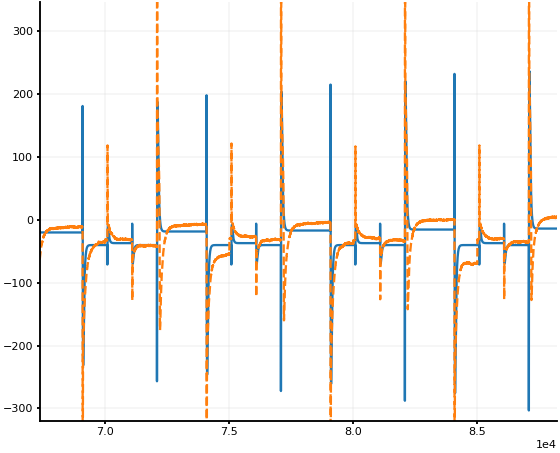

In [40]:
plt.plot(calculate_I_out(res.x, kwargs_for_count))
plt.plot(real_data_all, '--')
#plt.xlim(0, 1000)

### dual_annealing

In [ ]:
%%time
#res = scop.dual_annealing(loss, bounds=log_bounds, x0 = x_true_log, args=(real_data_small, kwargs_for_count), seed=42)

In [ ]:
res

In [ ]:
loss(res.x, real_data_small, kwargs)

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')